# Import necessary libraries

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import numpy as np
from nltk.tokenize import word_tokenize  
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import FunctionTransformer
from scipy.sparse import coo_matrix, hstack
from sklearn import metrics
!pip install -q transformers 
import torch
from torch import nn, optim
import tqdm.notebook as tq
import pickle
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from torch.utils.data import Dataset, DataLoader
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
import time
import scipy
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from torchsummary import summary

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
     |████████████████████████████████| 2.3MB 15.2MB/s 
     |████████████████████████████████| 3.3MB 51.4MB/s 
     |████████████████████████████████| 901kB 51.6MB/s 


In [ ]:
#functions to save and load models and data
def save(item,name):
    filename = '/content/drive/MyDrive/FakeNewsData/{}.sav'.format(name)
    pickle.dump(item, open(filename, 'wb'))
def load(name):
    filename = '/content/drive/MyDrive/FakeNewsData/{}.sav'.format(name)
    with open(filename, "rb") as fp:   # Unpickling
        temp = pickle.load(fp)
    return temp
def cycle(iterable):
    while True:
        for x in iterable:
            yield x

Number of training examples: 42476
Number of training examples: 7496
Number of testing examples: 25413


Text(0, 0.5, 'Stance')

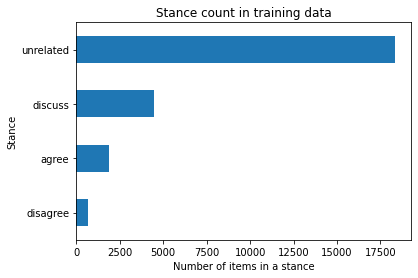

In [ ]:
bodies_df = pd.read_csv("/content/drive/MyDrive/FakeNewsData/train_bodies.csv")
stances_df = pd.read_csv("/content/drive/MyDrive/FakeNewsData/train_stances.csv")
test_bodies_df =pd.read_csv("/content/drive/MyDrive/FakeNewsData/competition_test_bodies.csv")
test_stances_df = pd.read_csv("/content/drive/MyDrive/FakeNewsData/competition_test_stances.csv")

train_data = pd.merge(bodies_df,stances_df,on="Body ID",how="inner")
train_data = train_data.drop("Body ID", axis=1)

validation_data = train_data.sample(frac=0.15,random_state=1)
train_data = train_data.drop(validation_data.index)

test_data = pd.merge(test_bodies_df,test_stances_df,on="Body ID",how="inner")
test_data = test_data.drop("Body ID", axis=1)

print(f"Number of training examples: {len(train_data)}")
print(f"Number of training examples: {len(validation_data)}")
print(f"Number of testing examples: {len(test_data)}")
test_data.Stance.value_counts().sort_values().plot(kind = 'barh')
plt.title("Stance count in training data")
plt.xlabel("Number of items in a stance")
plt.ylabel("Stance")
plt.savefig("/content/drive/MyDrive/FakeNewsData/Outputs/imbalance.png")

# TF-IDF 


In [ ]:
stop_words = set(stopwords.words("english"))

tfidfVect_body = TfidfVectorizer(sublinear_tf = True,decode_error='ignore', min_df=2,stop_words=None)
tfidfVect_head = TfidfVectorizer(sublinear_tf = True,decode_error='ignore', min_df=2,stop_words=None)

#train data tfidf
body_train_tfidf = tfidfVect_body.fit_transform(train_data.articleBody.values.astype('U'))
head_train_tfidf = tfidfVect_head.fit_transform(train_data.Headline.values.astype('U'))
#test data tfidf
body_test_tfidf = tfidfVect_body.transform(test_data.articleBody.values.astype('U'))
head_test_tfidf = tfidfVect_head.transform(test_data.Headline.values.astype('U'))
#validation data tfidf
body_validate_tfidf = tfidfVect_body.transform(validation_data.articleBody.values.astype('U'))
head_validate_tfidf = tfidfVect_head.transform(validation_data.Headline.values.astype('U'))

make the dataset binary

In [ ]:
binary_dict = {'unrelated':"unrelated", 'discuss':"related", 'agree':"related", 'disagree':"related"}

train_binary_stance = train_data.Stance.map(binary_dict)
test_binary_stance = test_data.Stance.map(binary_dict)
train_binary_stance.value_counts().sort_values().plot(kind = 'barh')
plt.title("Stance count in binary training data")
plt.xlabel("Number of items in a stance")
plt.ylabel("Stance")
plt.savefig("/content/drive/MyDrive/FakeNewsData/Outputs/imbalanceBinary.png")
combined_tfidf_train = hstack([body_train_tfidf,head_train_tfidf])
combined_tfidf_test = hstack([body_test_tfidf,head_test_tfidf])

# TFIDF Machine Learning

In [ ]:
def train_clf_tfidf(clf, name):
    start = time.time()
    clf.fit(combined_tfidf_train, list(train_binary_stance.values))
    final_t = time.time()-start
    print("{} classifier finished training, taking {:.0f} seconds".format(name,final_t))
    return clf
rf_classifier = RandomForestClassifier(n_estimators=10)
svm = SVC()
mlp_tfidf = MLPClassifier()
train_clf_tfidf(rf_classifier,"RandomForest")
train_clf_tfidf(svm, "SVM")
mlp_tfidf=train_clf_tfidf(mlp_tfidf, "MLP")

print("Models Trained")

RandomForest classifier finished training, taking 22 seconds
SVM classifier finished training, taking 6029 seconds
MLP classifier finished training, taking 1106 seconds
Models Trained


In [ ]:
def plot_results(classifier,name):
    y_true = list(test_binary_stance.values)
    y_data=combined_tfidf_test
    y_pred = classifier.predict(y_data)
    disp=metrics.ConfusionMatrixDisplay(metrics.confusion_matrix(y_true,y_pred,normalize=None),display_labels=classifier.classes_)
    disp.plot(cmap=plt.cm.Blues,values_format="")
    plt.title('Confusion matrix of {}'.format(name))
    plt.savefig("/content/drive/MyDrive/FakeNewsData/Outputs/{}_Matrix.png".format(name))
    print(metrics.classification_report(y_true,y_pred))

function to plot results

              precision    recall  f1-score   support

     related       0.33      0.45      0.38      7064
   unrelated       0.76      0.65      0.70     18349

    accuracy                           0.60     25413
   macro avg       0.54      0.55      0.54     25413
weighted avg       0.64      0.60      0.61     25413



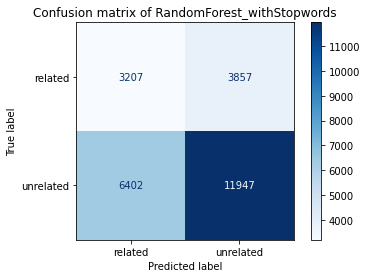

In [ ]:
plot_results(rf_classifier,"RandomForest_withStopwords")

              precision    recall  f1-score   support

     related       0.93      0.06      0.12      7064
   unrelated       0.73      1.00      0.85     18349

    accuracy                           0.74     25413
   macro avg       0.83      0.53      0.48     25413
weighted avg       0.79      0.74      0.64     25413



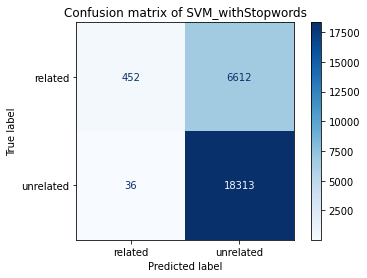

In [ ]:
plot_results(svm,"SVM_withStopwords")

In [ ]:
save(mlp_tfidf,"mlp_weights_stop")
save(svm,"svm_weights_stop")
save(rf_classifier,"rf_weights_stop")

tfidf results plotted from scores gathered from the classification report 

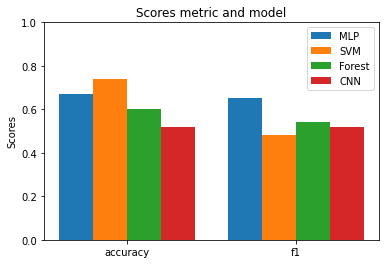

In [ ]:
#scores based on the confusion matrices generate above
import matplotlib.pyplot as plt
import numpy as np
#without stopwords
# metrics_labels=["accuracy","f1","precision","recall"]
metrics_labels=["accuracy","f1"]

X = np.arange(2)

# mlp = [0.99,0.98,0.98,0.98]
# svm = [0.97,0.96,0.94,0.98]
# rf = [0.94,0.93,0.91,0.94]
# cnn = [0.99,0.98,0.98,0.99]

svm=[0.74,0.48]
rf = [0.60,0.54]
mlp = [0.67,0.65]
cnn = [0.52,0.52]
ax = plt.subplot(111)

mlp_pl = ax.bar(X,mlp, width=0.20 )
svm_pl  = ax.bar(X+0.20,svm, width=0.20 )
rf_pl  = ax.bar(X+0.40,rf, width=0.20)
cnn_pl  = ax.bar(X+0.60,cnn, width=0.20)


ax.set_ylabel('Scores')
ax.set_title('Scores metric and model')
ax.set_xticks([0.3,1.3])
ax.set_xticklabels(metrics_labels)
ax.legend((mlp_pl[0],svm_pl[0],rf_pl[0],cnn_pl[0]),["MLP","SVM","Forest","CNN"],loc="upper right")
plt.ylim(0,1)

plt.savefig("tfidf_scores.png")

# Deep Learning Classification with TFIDF

              precision    recall  f1-score   support

     related       0.45      0.83      0.58      7064
   unrelated       0.90      0.61      0.73     18349

    accuracy                           0.67     25413
   macro avg       0.68      0.72      0.65     25413
weighted avg       0.78      0.67      0.69     25413



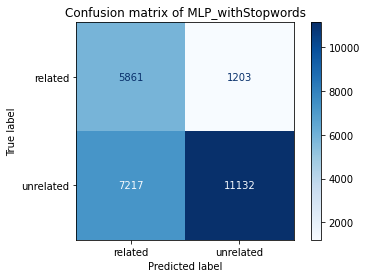

In [ ]:
plot_results(mlp_tfidf,"MLP_withStopwords")

dataset method for the TFIDF features

In [ ]:
class CombinedDataset(Dataset):
    def __init__(self,data,vectorizer_body=None,vectorizer_head=None,bert=None,binary=True,tfidf=True):
        self.tfidf = tfidf
        self.bert = bert
        self.data = data

        if self.bert:
            self.bodies = self.data.articleBody.apply(custom_tokenizer)
            self.headlines = self.data.Headline.apply(custom_tokenizer)
            self.tfidf=False
        else:
            self.bodies = self.data.articleBody
            self.headlines = self.data.Headline 

        if self.tfidf:
            self.vectorizer_body = vectorizer_body
            self.vectorizer_head = vectorizer_head 
            
        
        
        self.stances = self.data.Stance 
        if binary:
            binary_dict = {'unrelated':0, 'discuss':1, 'agree':1, 'disagree':1}
            self.stances = self.stances.map(binary_dict)
        else:
            multiple_dict = {'unrelated':0, 'discuss':1, 'agree':2, 'disagree':3}
            self.stances = self.stances.map(multiple_dict)

    def __len__(self):
        return len(self.data)
    def __getitem__(self,idx):
        body = self.bodies[idx:idx+1]
        headline = self.headlines[idx:idx+1]
        stance = self.stances.iloc[idx]
        stance = torch.tensor(stance).to(device)

        if self.tfidf:
            body = self.vectorizer_body.transform(body)
            headline = self.vectorizer_head.transform(headline)
            stacked = hstack([body,headline])
            stacked_tesnor = torch.tensor(scipy.sparse.csr_matrix.todense(stacked)).float().squeeze_().to(device)
            return stacked_tesnor,stance
        else:
            pass

        return body,headline,stance


train_dataset = CombinedDataset(train_data,tfidfVect_body,tfidfVect_head)
test_dataset = CombinedDataset(test_data,tfidfVect_body,tfidfVect_head)
validation_dataset = CombinedDataset(validation_data,tfidfVect_body,tfidfVect_head)

In [ ]:
train_loader = DataLoader(train_dataset,batch_size=64,shuffle=True)
test_loader = DataLoader(test_dataset,batch_size=64,shuffle=True)
validation_loader = DataLoader(validation_dataset,batch_size=64,shuffle=True)

model

In [ ]:
class BinaryStanceClassifier(nn.Module):
    def __init__(self,input_dim,output_dim,layer1_dim,layer2_dim):
        super(BinaryStanceClassifier, self).__init__()
        # self.classify = nn.Sequential(
        self.conv1 = nn.Sequential(nn.Conv1d(in_channels=input_dim,out_channels=layer1_dim,kernel_size=1),
        nn.ReLU(),
        nn.Dropout(0.2))
        self.conv2 = nn.Sequential(
        nn.Conv1d(in_channels=layer1_dim,out_channels=layer2_dim,kernel_size=1),
        nn.ReLU(),
        nn.Dropout(0.2))
        self.fc= nn.Linear(layer2_dim,output_dim)
        # )
    def forward(self,x):
        x = self.conv1(x)
        x = self.conv2(x)
        x.squeeze_()
        x = self.fc(x)
        return x

model = BinaryStanceClassifier(combined_tfidf_train.shape[1],2,500,64).to(device)

criterion = nn.BCEWithLogitsLoss().to(device)
max_epochs=10
optimizer = optim.Adam(model.parameters(), lr=0.002)


In [ ]:
train_losses = []
test_losses = []
validation_losses = []
train_iterator = cycle(train_loader)

training

In [ ]:
for e in range(max_epochs):
    temp=[]
    # for features,stances in train_loader:  
    for _ in range(200):  
        features,stances = next(train_iterator)

        optimizer.zero_grad()
        features.unsqueeze_(2)
        stance_prediction = model(features)
        loss = criterion(stance_prediction, stances)
        loss.backward()
        train_loss = loss.item()
        temp.append(train_loss)
        optimizer.step()
    train_losses.append(sum(temp)/len(temp))

    model.eval()
    temp=[]
    with torch.no_grad():
        # features,stances = next(validation_iterator)
        for features,stances in validation_loader:
            features.unsqueeze_(2)
            stance_prediction = model(features)
            val_loss = criterion(stance_prediction, stances)
            temp.append(val_loss.item())
    validation_losses.append(sum(temp)/len(temp))
    print(f"Epoch: {e+1}/{max_epochs}.. ",
          f"Training Loss: {train_losses[-1]:.4f}.. ",
          f"Validation Loss: {validation_losses[-1]:.4f}.. ")


Epoch: 1/15..  Training Loss: 0.0080..  Validation Loss: 0.0233.. 
Epoch: 2/15..  Training Loss: 0.0079..  Validation Loss: 0.0259.. 
Epoch: 3/15..  Training Loss: 0.0056..  Validation Loss: 0.0225.. 
Epoch: 4/15..  Training Loss: 0.0034..  Validation Loss: 0.0209.. 
Epoch: 5/15..  Training Loss: 0.0034..  Validation Loss: 0.0217.. 
Epoch: 6/15..  Training Loss: 0.0038..  Validation Loss: 0.0246.. 
Epoch: 7/15..  Training Loss: 0.0029..  Validation Loss: 0.0205.. 
Epoch: 8/15..  Training Loss: 0.0028..  Validation Loss: 0.0232.. 
Epoch: 9/15..  Training Loss: 0.0036..  Validation Loss: 0.0239.. 
Epoch: 10/15..  Training Loss: 0.0013..  Validation Loss: 0.0236.. 
Epoch: 11/15..  Training Loss: 0.0015..  Validation Loss: 0.0240.. 
Epoch: 12/15..  Training Loss: 0.0020..  Validation Loss: 0.0217.. 
Epoch: 13/15..  Training Loss: 0.0002..  Validation Loss: 0.0253.. 
Epoch: 14/15..  Training Loss: 0.0031..  Validation Loss: 0.0244.. 
Epoch: 15/15..  Training Loss: 0.0037..  Validation Loss:

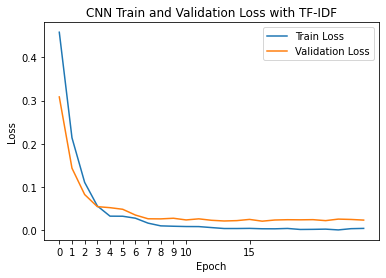

In [ ]:
l1 = plt.plot(train_losses,label="Train Loss")
l2 = plt.plot(validation_losses, label="Validation Loss")
plt.title("CNN Train and Validation Loss with TF-IDF")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.xticks([0,1,2,3,4,5,6,7,8,9,10])
plt.savefig("/content/drive/MyDrive/FakeNewsData/Outputs/CNN_TFIDF.png")

In [ ]:
torch.save(model.state_dict(), "/content/drive/MyDrive/FakeNewsData/DeepLWeights/tfidfDL")

              precision    recall  f1-score   support

           0       0.95      0.36      0.52     18349
           1       0.36      0.96      0.53      7064

    accuracy                           0.52     25413
   macro avg       0.66      0.66      0.52     25413
weighted avg       0.79      0.52      0.52     25413



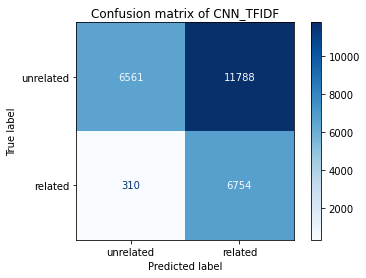

In [ ]:
def test_model(model,test_loader):
    model.eval()
    y_true = []
    y_pred=[]
    with torch.no_grad():
        for features,stances in test_loader:
            features.unsqueeze_(2)
            probabilities = model(features)
            probabilities = probabilities.detach().cpu().numpy()
            predictions = np.argmax(probabilities, axis=1)

            y_true.extend(stances.cpu().numpy())
            y_pred.extend(predictions)
    print(metrics.classification_report(y_true,y_pred))
    disp=metrics.ConfusionMatrixDisplay(metrics.confusion_matrix(y_true,y_pred,normalize=None),display_labels=["unrelated","related"])
    disp.plot(cmap=plt.cm.Blues,values_format="")
    plt.title('Confusion matrix of {}'.format("CNN_TFIDF"))
    plt.savefig("/content/drive/MyDrive/FakeNewsData/Outputs/{}_Matrix.png".format("CNN_TFIDF"))
test_model(model,test_loader)

# BERT Transformer

import the bert model

In [ ]:
from transformers import BertModel, BertConfig, BertTokenizer, Trainer,TrainingArguments,BertForSequenceClassification
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased').to(device)
max_input_length = tokenizer.max_model_input_sizes['bert-base-uncased'] #512

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
train_labels = train_data["Stance"]
test_labels = test_data["Stance"]
validation_labels = validation_data["Stance"]

tokenize the training and testing data

In [ ]:
def tokenizeData(data):
    bodies = list(data.articleBody.values)
    headlines = list(data.Headline.values)
    tok = tokenizer(bodies,headlines,return_tensors="pt",truncation=True,padding="max_length")
    # tok_headlines = tokenizer(headlines,truncation=True,paddint="max_length")
    return tok
def getEmbeddings(data,numpy=True,output="pooler_output"):
    embeddingsList=[]
    x=2
    with torch.no_grad():
        for i in tqdm(range(0,len(data["input_ids"]),x)):
            embeddings = bert_model(data["input_ids"][i:i+x].to(device),data["attention_mask"][i:i+x].to(device),data["token_type_ids"][i:i+x].to(device))[output]
            embeddingsList.extend(embeddings.squeeze_().squeeze_())
    if numpy:
        embed_np = [x.cpu().numpy() for x in embeddingsList]
        return embeddingsList,embed_np
    else:
        return embeddingsList
def pytorchToNumpy(tensors):
    embed_np = [x.cpu().numpy() for x in tensors]
    return embed_np

In [ ]:
train_bert = tokenizeData(train_data)
validation_bert = tokenizeData(validation_data)
test_bert = tokenizeData(test_data)
#input_ids, attnetion_mask, token_type_ids

In [ ]:
save(train_bert,"train_bert_tokens")
save(validation_bert,"validation_bert_tokens")
save(test_bert,"test_bert_tokens")

In [ ]:
train_bert = load("train_bert_tokens")
validation_bert = load("validation_bert_tokens")
test_bert = load("test_bert_tokens")

In [ ]:
train_embed_pt, train_embed_np = getEmbeddings(train_bert)
test_embed_pt, test_embed_np = getEmbeddings(test_bert)
validation_embed_pt, valistaion_embed_np = getEmbeddings(validation_bert)

In [ ]:
save(train_embed_pt,"train_embed_pt")
save(test_embed_pt,"test_embed_pt")
save(validation_embed_pt,"validation_embed_pt")

In [ ]:
train_embed_pt = load("train_embed_pt")
test_embed_pt = load("test_embed_pt")
validation_embed_pt = load("validation_embed_pt")

convert to numpy to pass to sklearn

In [ ]:
train_embed_np = pytorchToNumpy(train_embed_pt)
test_embed_np = pytorchToNumpy(test_embed_pt) 
validation_embed_np = pytorchToNumpy(validation_embed_pt) 

# Train ML and DL Methods

In [ ]:
rf_classifier = RandomForestClassifier(n_estimators=10)
rf_classifier.fit(train_embed_np, list(train_binary_stance.values))

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
svm = SVC()
svm.fit(train_embed_np,list(train_binary_stance.values))

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
mlp = MLPClassifier(hidden_layer_sizes=[768,512,256,128,64],learning_rate="adaptive",max_iter=600)
mlp.fit(train_embed_np,list(train_binary_stance.values))

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=[768, 512, 256, 128, 64],
              learning_rate='adaptive', learning_rate_init=0.001, max_fun=15000,
              max_iter=600, momentum=0.9, n_iter_no_change=10,
              nesterovs_momentum=True, power_t=0.5, random_state=None,
              shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
              verbose=False, warm_start=False)

In [ ]:
save(mlp,"mlp_bert")
save(svm,"svm_bert")
save(rf_classifier,"rf_bert")

In [ ]:
def plot_results_bert(classifier,name,test_data,target):
    y_true =  target
    y_data = test_data
    y_pred = classifier.predict(y_data)
    disp=metrics.ConfusionMatrixDisplay(metrics.confusion_matrix(y_true,y_pred,normalize=None),display_labels=classifier.classes_)
    disp.plot(cmap=plt.cm.Blues,values_format="")
    plt.title('Confusion matrix of {}'.format(name))
    plt.savefig("/content/drive/MyDrive/FakeNewsData/Outputs/{}_Matrix.png".format(name))
    print(metrics.classification_report(y_true,y_pred))

# BERT Machine Learning Results

              precision    recall  f1-score   support

     related       0.96      0.96      0.96      7064
   unrelated       0.98      0.98      0.98     18349

    accuracy                           0.98     25413
   macro avg       0.97      0.97      0.97     25413
weighted avg       0.98      0.98      0.98     25413



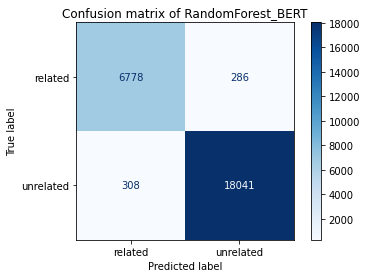

In [ ]:
plot_results_bert(rf_classifier,"RandomForest_BERT")

              precision    recall  f1-score   support

     related       0.95      0.96      0.96      7064
   unrelated       0.98      0.98      0.98     18349

    accuracy                           0.98     25413
   macro avg       0.97      0.97      0.97     25413
weighted avg       0.98      0.98      0.98     25413



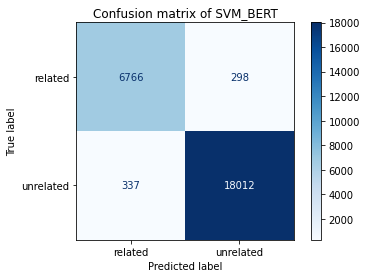

In [ ]:
plot_results_bert(svm,"SVM_BERT")

              precision    recall  f1-score   support

     related       0.96      0.97      0.97      7064
   unrelated       0.99      0.98      0.99     18349

    accuracy                           0.98     25413
   macro avg       0.97      0.98      0.98     25413
weighted avg       0.98      0.98      0.98     25413



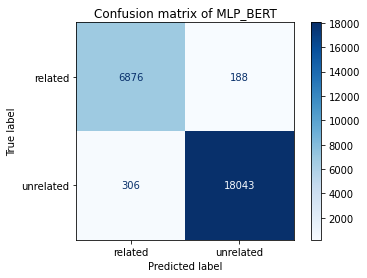

In [ ]:
plot_results_bert(mlp,"MLP_BERT",test_embed_np,list(test_binary_stance.values))

# Dataset used for BERT model encoding

In [ ]:
class BERT_Data(Dataset):
    def __init__(self,data,target,binary=True):
        self.stances = target
        self.data = data
        if binary:
            binary_dict = {'unrelated':0, 'discuss':1, 'agree':1, 'disagree':1}
            self.stances = self.stances.map(binary_dict)
        else:
            multiple_dict = {'unrelated':0, 'discuss':1, 'agree':2, 'disagree':3}
            self.stances = self.stances.map(multiple_dict)
        self.stances = list(self.stances.values)
    def __len__(self):
        return len(self.data)
    def __getitem__(self,idx):
        x = self.data[idx]
        x = x.to(device)
        stance = float(self.stances[idx])
        stance = torch.tensor(stance).to(device)

        return x,stance

train_dataset_bert = BERT_Data(train_embed_pt,train_labels)
test_dataset_bert = BERT_Data(test_embed_pt,test_labels)
validation_dataset_bert = BERT_Data(validation_embed_pt,train_labels)

train_loader_bert = DataLoader(train_dataset_bert,batch_size=64,shuffle=True)
test_loader_bert = DataLoader(test_dataset_bert,batch_size=64,shuffle=True)
validation_loader_bert = DataLoader(validation_dataset_bert,batch_size=64,shuffle=True)

In [ ]:
class BinaryBert(nn.Module):
    def __init__(self,input_dim):
        super(BinaryBert, self).__init__()
        # self.classify = nn.Sequential(
        self.conv1 = nn.Sequential(nn.Conv1d(in_channels=input_dim,out_channels=512,kernel_size=1,stride=2),
        nn.ReLU(),
        nn.Dropout(0.2))
        self.conv2 = nn.Sequential(
        nn.Conv1d(in_channels=512,out_channels=256,kernel_size=1,stride=2),
        nn.ReLU(),
        nn.Dropout(0.2))
        self.conv3 = nn.Sequential(
        nn.Conv1d(in_channels=256,out_channels=128,kernel_size=1),
        nn.ReLU(),
        nn.Dropout(0.2))
        self.fc= nn.Linear(128,1)
        self.relu = nn.LeakyReLU()

        
        self.sigmoid = nn.Sigmoid()
    def forward(self,x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)

        x = x.squeeze()
        x = self.fc(x)
        x = self.sigmoid(x)
        return x


bert_output_size = 768
cnnBert = BinaryBert(bert_output_size).to(device)
criterion = nn.BCELoss().to(device)
max_epochs=10
optimizer = optim.Adam(cnnBert.parameters(), lr=0.0002)
summary(cnnBert,(768,1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1               [-1, 512, 1]         393,728
              ReLU-2               [-1, 512, 1]               0
           Dropout-3               [-1, 512, 1]               0
            Conv1d-4               [-1, 256, 1]         131,328
              ReLU-5               [-1, 256, 1]               0
           Dropout-6               [-1, 256, 1]               0
            Conv1d-7               [-1, 128, 1]          32,896
              ReLU-8               [-1, 128, 1]               0
           Dropout-9               [-1, 128, 1]               0
           Linear-10                    [-1, 1]             129
          Sigmoid-11                    [-1, 1]               0
Total params: 558,081
Trainable params: 558,081
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

In [ ]:
train_iterator_bert = cycle(train_loader_bert)
test_iterator_bert = cycle(test_loader_bert)
validation_iterator_bert = cycle(validation_loader_bert)

In [ ]:
train_losses_bert = []
validation_losses_bert = []
act = nn.Sigmoid()
for e in range(max_epochs):
    temp=[]
    # for features,stances in train_loader:  
    for features,stances in train_loader_bert:  
    # for features,stances in train_loader_bert:
        optimizer.zero_grad()
        features = features.unsqueeze(2)
        stance_prediction = cnnBert(features)
        stance_prediction = stance_prediction.squeeze()
        loss = criterion(stance_prediction, stances)
        loss.backward()
        train_loss = loss.item()
        temp.append(train_loss)
        optimizer.step()
    train_losses_bert.append(sum(temp)/len(temp))

    temp=[]
    with torch.no_grad():
        for _ in range(200):
            features,stances = next(validation_iterator_bert)
            features = features.unsqueeze(2)
            stance_prediction = cnnBert(features)
            stance_prediction = stance_prediction.squeeze()
            val_loss = criterion(stance_prediction, stances)
            temp.append(val_loss.item())
    validation_losses_bert.append(sum(temp)/len(temp))
    print(f"Epoch: {e+1}/{max_epochs}.. ",f"Training Loss: {train_losses_bert[-1]:.4f}.. ",f"Validation Loss: {validation_losses_bert[-1]:.4f}.. ")


Epoch: 1/10..  Training Loss: 0.0825..  Validation Loss: 1.6460.. 
Epoch: 2/10..  Training Loss: 0.0834..  Validation Loss: 1.7286.. 
Epoch: 3/10..  Training Loss: 0.0813..  Validation Loss: 1.2411.. 
Epoch: 4/10..  Training Loss: 0.0804..  Validation Loss: 1.6854.. 
Epoch: 5/10..  Training Loss: 0.0801..  Validation Loss: 1.5093.. 
Epoch: 6/10..  Training Loss: 0.0797..  Validation Loss: 1.3201.. 
Epoch: 7/10..  Training Loss: 0.0796..  Validation Loss: 1.6827.. 
Epoch: 8/10..  Training Loss: 0.0777..  Validation Loss: 2.1682.. 
Epoch: 9/10..  Training Loss: 0.0783..  Validation Loss: 1.4584.. 
Epoch: 10/10..  Training Loss: 0.0773..  Validation Loss: 1.6696.. 


              precision    recall  f1-score   support

         0.0       0.98      0.99      0.98     18349
         1.0       0.97      0.93      0.95      7064

    accuracy                           0.97     25413
   macro avg       0.97      0.96      0.97     25413
weighted avg       0.97      0.97      0.97     25413



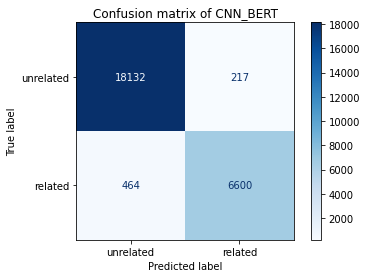

In [ ]:
def test_model(model,test_loader):
    model.eval()
    y_true = []
    y_pred=[]
    with torch.no_grad():
        for features,stances in test_loader:
            features = features.unsqueeze(2)
            stance_prediction = cnnBert(features)
            probabilities = stance_prediction.squeeze()
            probabilities = probabilities.detach().cpu().numpy()
            predictions = [round(x) for x in probabilities]
            # predictions = np.argmax(probabilities, axis=1)

            y_true.extend(stances.cpu().numpy())
            y_pred.extend(predictions)

    print(metrics.classification_report(y_true,y_pred))
    disp=metrics.ConfusionMatrixDisplay(metrics.confusion_matrix(y_true,y_pred,normalize=None),display_labels=["unrelated","related"])
    disp.plot(cmap=plt.cm.Blues,values_format="")
    plt.title('Confusion matrix of {}'.format("CNN_BERT"))
    plt.savefig("/content/drive/MyDrive/FakeNewsData/Outputs/{}_Matrix.png".format("CNN_BERT"))
test_model(cnnBert,test_loader_bert)

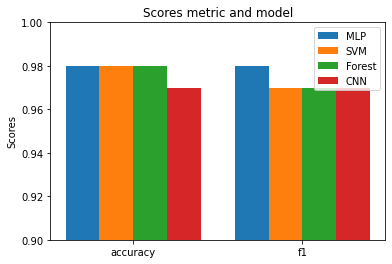

In [ ]:
#scores based on the confusion matrices generate above
import matplotlib.pyplot as plt
import numpy as np
metrics_labels=["accuracy","f1"]

X = np.arange(2)


svm=[0.98,0.97]
rf = [0.98,0.97]
mlp = [0.98,0.98]
cnn = [0.97,0.97]
ax = plt.subplot(111)

mlp_pl = ax.bar(X,mlp, width=0.20 )
svm_pl  = ax.bar(X+0.20,svm, width=0.20 )
rf_pl  = ax.bar(X+0.40,rf, width=0.20)
cnn_pl  = ax.bar(X+0.60,cnn, width=0.20)


ax.set_ylabel('Scores')
ax.set_title('Scores metric and model')
ax.set_xticks([0.3,1.3])
ax.set_xticklabels(metrics_labels)
ax.legend((mlp_pl[0],svm_pl[0],rf_pl[0],cnn_pl[0]),["MLP","SVM","Forest","CNN"],loc="upper right")
plt.ylim(0.9,1)

plt.savefig("bert_scores.png")

# Multi Stance Classification

# Create the Multi-class Dataset and Train DL Model

In [ ]:
def dropUnrelated(df):
    df = df[df.Stance != 4]
    return df
trainMulti = train_data.copy()
testMulti = test_data.copy()
validationMulti = validation_data.copy()
multiple_dict = {'unrelated':4, 'discuss':0, 'agree':1, 'disagree':2}
trainMulti.Stance, testMulti.Stance, validationMulti.Stance = trainMulti.Stance.map(multiple_dict), testMulti.Stance.map(multiple_dict),validationMulti.Stance.map(multiple_dict) 
trainMulti, testMulti, validationMulti = dropUnrelated(trainMulti), dropUnrelated(testMulti),dropUnrelated(validationMulti)

trainMulti now has 11431 rows
testMulti has 7064 rows and 
validationMulti has 1996 rows

In [ ]:
trainMultiBert = getEmbeddings(tokenizeData(trainMulti))
testMultiBert =  getEmbeddings(tokenizeData(testMulti))
validationMultiBert =  getEmbeddings(tokenizeData(validationMulti))

In [ ]:
save(trainMultiBert,"trainMultiBert")
save(testMultiBert,"testMultiBert")
save(validationMultiBert,"validationMultiBert")

In [ ]:
train_Multi_tokens = tokenizeData(trainMulti)
test_Multi_token = tokenizeData(testMulti)
validation_Multi_token = tokenizeData(validationMulti)

In [ ]:
save(train_Multi_tokens,"train_Multi_tokens")
save(test_Multi_token,"test_Multi_token")
save(validation_Multi_token,"validation_Multi_token")

In [ ]:
train_Multi_tokens=load("train_Multi_tokens")
test_Multi_token=load("test_Multi_token")
validation_Multi_token=load("validation_Multi_token")

In [ ]:
class BERT_Data_MultiClass(Dataset):
    def __init__(self,data,target,binary=True):
        self.stances = target
        self.data = data
        self.stances = list(self.stances.values)
    def __len__(self):
        return len(self.data["input_ids"])
    def __getitem__(self,idx):
        # stance = torch.zeros(3,dtype=torch.long)
        # stance[self.stances[idx]-1] = 1
        stance = self.stances[idx]
        stance = torch.tensor(stance).to(device)
        with torch.no_grad():
            embedding = bert_model(self.data["input_ids"][idx:idx+1].to(device),self.data["attention_mask"][idx:idx+1].to(device),self.data["token_type_ids"][idx:idx+1].to(device))[0]

        return embedding,stance

trainMulti_dataset_bert = BERT_Data_MultiClass(train_Multi_tokens,trainMulti.Stance)
testMulti_dataset_bert = BERT_Data_MultiClass(test_Multi_token,testMulti.Stance)
validationMulti_dataset_bert = BERT_Data_MultiClass(validation_Multi_token,validationMulti.Stance)

trainMulti_loader_bert = DataLoader(trainMulti_dataset_bert,batch_size=16,shuffle=True)
testMulti_loader_bert = DataLoader(testMulti_dataset_bert,batch_size=16,shuffle=True)
validationMulti_loader_bert = DataLoader(validationMulti_dataset_bert,batch_size=16,shuffle=True)

In [ ]:
class BERT_GRU(nn.Module):
    def __init__(self):
        super(BERT_GRU,self).__init__()
        self.rnn = nn.GRU(768,256,num_layers=2,bidirectional=True,dropout=0,batch_first=True)
        self.fc = nn.Linear(256,3) #output probabilities for each of the 3 classes: discuss, agree, disagree
        self.dropout = nn.Dropout(0.2)

    def forward(self,x):
        _,hidden = self.rnn(x)
        hidden = self.dropout(hidden[-1,:,:])
        hidden = self.fc(hidden)
        return hidden
gru = BERT_GRU().to(device)
def multi_acc(preds, y):
    """
    Returns accuracy per batch
    """
    #round predictions to the closest integer
    y_pred_softmax = torch.log_softmax(preds, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)  
    # print(y_pred_tags)
    # rounded_preds = torch.round(y_pred_tags)
    correct = (y_pred_tags == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc
best_valid_loss = float('inf')


In [ ]:
multi_optimizer = optim.Adam(gru.parameters(),lr=0.0002)
multi_criterion = nn.CrossEntropyLoss().to(device)

In [ ]:
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for x,y in iterator:

        optimizer.zero_grad()

        predictions = model(x.squeeze()).squeeze(1)
        loss = criterion(predictions, y)
        
        acc = multi_acc(predictions, y)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for x,y in iterator:

            predictions = model(x.squeeze()).squeeze(1)
            
            loss = criterion(predictions, y)
            
            acc = multi_acc(predictions, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs
max_epochs=15
epoch=0

In [ ]:
#code for training adapted from practical 3
while epoch<max_epochs:
    start_time = time.time()

    train_loss, train_acc = train(gru,trainMulti_loader_bert,multi_optimizer,multi_criterion)
    valid_loss, valid_acc = evaluate(gru,validationMulti_loader_bert,multi_criterion)
    
    end_time=time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(gru.state_dict(), '/content/drive/MyDrive/FakeNewsData/Outputs/bertMultiModel4layers.pt')
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
    epoch+=1



In [ ]:
gru.load_state_dict(torch.load('/content/drive/MyDrive/FakeNewsData/Outputs/bertMultiModel.pt')) #load the given directory

<All keys matched successfully>

              precision    recall  f1-score   support

           0       0.84      0.73      0.78      4464
           1       0.47      0.73      0.57      1903
           2       0.33      0.11      0.17       697

    accuracy                           0.67      7064
   macro avg       0.55      0.52      0.51      7064
weighted avg       0.69      0.67      0.66      7064



(1.3026169889450612, 0.666289592760181)

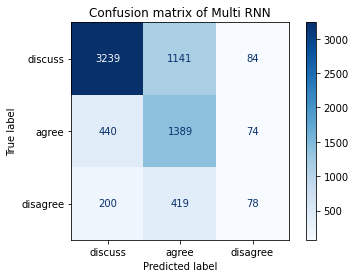

In [ ]:
def testMultiRNN(model, iterator,criterion):
    model.eval()
    y_pred = []
    y_true = []
    with torch.no_grad():
        epoch_loss = 0
        epoch_acc = 0
        for x,y in iterator:
            predictions = model(x.squeeze()).squeeze(1)
            
            loss = criterion(predictions, y)
            
            acc = multi_acc(predictions, y)
            y_pred_softmax = torch.log_softmax(predictions, dim = 1)
            _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)  
            y_pred.extend(y_pred_tags.cpu().numpy())
            y_true.extend(y.cpu().numpy())
            epoch_loss += loss.item()
            epoch_acc += acc.item()
    disp=metrics.ConfusionMatrixDisplay(metrics.confusion_matrix(y_true,y_pred,normalize=None),display_labels=['discuss', 'agree', 'disagree'])
    disp.plot(cmap=plt.cm.Blues,values_format="")
    plt.title('Confusion matrix of {}'.format("Multi RNN"))
    plt.savefig("/content/drive/MyDrive/FakeNewsData/Outputs/{}_Matrix.png".format("Multi RNN"))
    print(metrics.classification_report(y_true,y_pred))
    return epoch_loss / len(iterator), epoch_acc / len(iterator)
testMultiRNN(gru,testMulti_loader_bert,multi_criterion)

In [ ]:
mlpMulti = MLPClassifier(hidden_layer_sizes=[768,512,256,128,64],learning_rate="adaptive",max_iter=600)
mlpMulti.fit(trainMultiBert[1],list(trainMulti.Stance.values))

              precision    recall  f1-score   support

           1       0.67      0.88      0.76      4464
           2       0.40      0.26      0.32      1903
           3       0.00      0.00      0.00       697

    accuracy                           0.62      7064
   macro avg       0.36      0.38      0.36      7064
weighted avg       0.53      0.62      0.57      7064



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


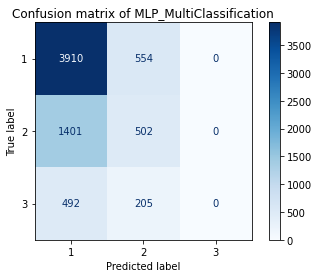

In [ ]:
plot_results_bert(mlpMulti,"MLP_MultiClassification",testMultiBert[1],list(testMulti.Stance.values))

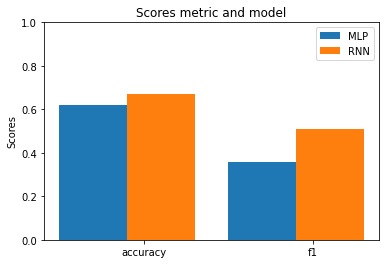

In [ ]:
#scores based on the confusion matrices generate above
import matplotlib.pyplot as plt
import numpy as np
metrics_labels=["accuracy","f1"]

X = np.arange(2)


mlp = [0.62,0.36]
rnn = [0.67,0.51]
ax = plt.subplot(111)

mlp_pl = ax.bar(X,mlp, width=0.40 )
rnn_pl  = ax.bar(X+0.40,rnn, width=0.40)


ax.set_ylabel('Scores')
ax.set_title('Scores metric and model')
ax.set_xticks([0.3,1.3])
ax.set_xticklabels(metrics_labels)
ax.legend((mlp_pl[0],rnn_pl[0]),["MLP","RNN"],loc="upper right")
plt.ylim(0,1)

plt.savefig("bertMulti_scores.png")

# Test architecture end-to-end

In [ ]:
gold_labels = test_data.pop("Stance")

In [ ]:
all_test_tokens = tokenizeData(test_data) 
save(all_test_tokens,"all_test_tokens")

In [ ]:
all_test_tokens = load("all_test_tokens")

In [ ]:
binary_mlp = load("mlp_bert")

In [ ]:
true_labels = list(gold_labels.values)

In [ ]:
y_pred = []
score = 0
related = ["discuss","agree","disagree"]
gru.eval()
for i in tqdm(range(len(all_test_tokens["input_ids"]))):
    with torch.no_grad():
        embedding = bert_model(all_test_tokens["input_ids"][i:i+1].to(device),all_test_tokens["attention_mask"][i:i+1].to(device),all_test_tokens["token_type_ids"][i:i+1].to(device))
        prediction = binary_mlp.predict(embedding[1].cpu().numpy())
        if prediction=="unrelated":
            name_prediction="unrelated"
        else:
            prediction = gru(embedding[0])
            y_pred_softmax = torch.log_softmax(prediction, dim = 1)
            _, prediction = torch.max(y_pred_softmax, dim = 1)
            prediction = prediction.item()
            if prediction==0:
                name_prediction = "discuss"
            elif prediction==1:
                name_prediction = "agree"
            elif prediction==2:
                name_prediction = "disagree"
        y_pred.append(name_prediction) 
        if name_prediction == true_labels[i]:
            score+=0.25
            if name_prediction != "unrelated":
                score+=0.5
        if name_prediction in related and true_labels[i] in related:
            score += 0.25
print("Final score of model is: {}".format(score))


Final score of model is: 9669.25


              precision    recall  f1-score   support

       agree       0.46      0.72      0.56      1903
    disagree       0.29      0.10      0.15       697
     discuss       0.79      0.71      0.75      4464
   unrelated       0.99      0.98      0.99     18349

    accuracy                           0.89     25413
   macro avg       0.63      0.63      0.61     25413
weighted avg       0.90      0.89      0.89     25413



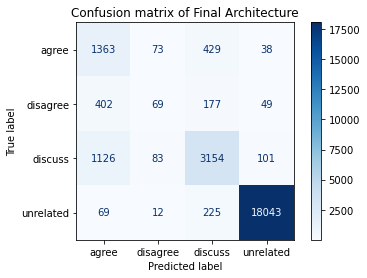

In [ ]:
disp=metrics.ConfusionMatrixDisplay(metrics.confusion_matrix(true_labels,y_pred,normalize=None),display_labels=["agree","disagree","discuss","unrelated"])
disp.plot(cmap=plt.cm.Blues,values_format="")
plt.title('Confusion matrix of {}'.format("Final Architecture"))
plt.savefig("/content/drive/MyDrive/FakeNewsData/Outputs/{}_Matrix.png".format("Final Architecture"))
print(metrics.classification_report(true_labels,y_pred))